In [1]:
import numpy as np
from z3 import *
from itertools import product, groupby, count
from sympy import primerange
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

In [7]:
board = np.array([[ 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                  [ 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                  [ 2, 2, 3, 3, 3, 3, 4, 4, 4, 1, 4],
                  [ 2, 3, 3, 2, 3, 5, 4, 4, 4, 4, 4],
                  [ 2, 3, 3, 2, 3, 5, 5, 4, 4, 5, 4],
                  [ 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 4],
                  [ 2, 6, 7, 7, 2, 2, 5, 5, 7, 5, 5],
                  [ 2, 6, 7, 7, 7, 7, 7, 7, 7, 8, 8],
                  [ 6, 6, 6, 6, 7, 6, 7, 8, 8, 8, 8],
                  [ 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
                  [ 6, 6, 9, 9, 9, 9, 9, 9, 6, 6, 6]], dtype=int)

board_yellow = np.array([[0,0,0,0,0,0,0,0,0,0,0],
                         [0,0,0,1,1,0,0,0,0,0,0],
                         [0,0,0,0,1,0,0,0,0,1,0],
                         [0,0,0,0,0,0,0,0,1,1,0],
                         [0,0,0,0,0,0,0,0,0,0,0],
                         [0,0,0,0,0,1,0,0,0,0,0],
                         [0,1,1,0,0,1,1,0,0,0,0],
                         [0,1,0,0,0,1,0,0,0,0,0],
                         [0,0,0,0,1,1,0,0,0,0,0],
                         [0,0,0,0,1,0,0,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0]], dtype=int)

demo = np.array([[1,1,1,1,1],
                 [2,1,1,1,1],
                 [2,2,1,1,1],
                 [3,2,2,1,1],
                 [3,3,2,2,1]], dtype=int)

demo_yellow = np.array([[1,1,0,0,0],
                        [1,0,0,0,0],
                        [0,0,0,0,0],
                        [0,0,0,0,1],
                        [0,0,0,1,1]], dtype=int)

In [8]:
def plot_model_with_annotations(model: ModelRef, X: np.ndarray, N: int, board: np.ndarray, answer: bool) -> None:
    arr = np.zeros((N,N), dtype=int)
    for i,j in product(range(N), repeat=2):
        arr[i][j] = model.eval(X[i][j]).as_long()
            
    total = 0
    for row in arr:
        groups = ["".join(str(x) for x in group) for key,group in groupby(row, lambda x: x==0) if not key]
        total += sum([int(group) for group in groups])

    unique_values = np.unique(board)
    color_map_index = {val: idx for idx,val in enumerate(unique_values)}
    cmap = plt.get_cmap('Spectral', len(unique_values))
    norm = plt.Normalize(0, len(unique_values) - 1)
    color_array = cmap(norm([color_map_index[val] for val in board.ravel()])) 
    color_array = color_array.reshape(board.shape + (4,))

    mask = arr==0
    color_array[mask] = [0, 0, 0, 1]
    _, ax = plt.subplots(figsize=(10, 10))
    _ = ax.imshow(color_array, vmin=0, vmax=1)

    for i,j in product(range(N), repeat=2):
        label = '' if arr[i][j] == 0 else str(arr[i][j])
        ax.text(j, i, label, va='center', ha='center', color='white' if mask[i][j] else 'black')

    ax.set_xticks(np.arange(-.5, N, 1), minor=False)
    ax.set_yticks(np.arange(-.5, N, 1), minor=False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(which='major', color='black', linestyle='-', linewidth=2)
    plt.grid(True)
    if answer:
        display(Markdown('### Answer is: {:,.0f}'.format(total)))
    plt.show()

In [9]:
make_grid = lambda N, s: np.array(IntVector(f"{s}", N**2), dtype=object).reshape((N,N))
orthogonal = lambda i, j, N: [(i+di,j+dj) for (di,dj) in [(0,1),(1,0),(-1,0),(0,-1)] if 0<=i+di<N and 0<=j+dj<N]

def generate_arrays(yellow: np.ndarray, row: int) -> list[tuple]:
    n = len(yellow)
    condition = lambda arr: arr[1] != 0 and arr[-2] != 0 and \
        all(not (arr[i]==0 and arr[i+2]==0) for i in range(n-2)) and \
        all(not (arr[i]==0 and arr[i+1]==0) for i in range(n-1)) and \
        all(not (arr[i]==0 and yellow[row][i]==1) for i in range(n))
    return [arr for arr in product([0,1], repeat=n) if condition(arr)]

index_groups_one = lambda tup: list[tuple]([tuple(idx for idx,_ in group) for key,group in groupby(enumerate(tup), lambda x: x[1] == 1) if key])
generate_block_indices = lambda yellow, row: dict[tuple, list[tuple]]({tup: index_groups_one(tup) for tup in generate_arrays(yellow, row)})

In [20]:
# FIXME
# Prime condition not working
# Does not guarantee all concatenated numbers are unique


def solve(grid: np.ndarray, yellow: np.ndarray) -> None:
    s = Solver()
    N = len(grid)
    X, Y = make_grid(N,'x'), make_grid(N, 'y')
    
    valid_section = lambda row, tup: And([If(val==1, Y[row][c]>=1, Y[row][c]==0) for c,val in enumerate(tup)])
    concat_number = lambda row, group: Sum([Y[row][tup_idx]*10**(len(group)-idx-1) for idx,tup_idx in enumerate(group)])
    
    ends_in = lambda row, numbers: And(And([Implies(Y[row][c]==0, Or([Y[row][c-1]==n for n in numbers])) for c in range(2, N)]), 
                                   Or([Y[row][-1]==n for n in numbers+[0]]))
    
    multiple_of_helper = lambda row, group, n: concat_number(row, group) % n == 0
    multiple_of = lambda row, val: Or(*[And(valid_section(row, tup), *[multiple_of_helper(row, g, val) for g in groups]) 
                                        for tup,groups in generate_block_indices(yellow, row).items()])
    
    _sq_ctr = count()
    def is_perfect_square(expr: Int) -> And:
        s = Int(f"sqrt_{next(_sq_ctr)}")
        return And(s >= 0, s * s == expr)

    square_helper = lambda row, group: is_perfect_square(concat_number(row, group))
    perfect_square = lambda row: Or(*[And(valid_section(row, tup), *[square_helper(row, g) for g in groups]) 
                                      for tup, groups in generate_block_indices(yellow, row).items()])
    
    def is_fibonacci(expr: Int) -> Or:
        five_n2 = 5 * expr * expr
        return Or(is_perfect_square(five_n2 + 4), is_perfect_square(five_n2 - 4))

    fib_helper = lambda row, group: is_fibonacci(concat_number(row, group))
    fibonacci_row = lambda row: Or(*[And(valid_section(row, tup), *[fib_helper(row, g) for g in groups])
                                     for tup, groups in generate_block_indices(yellow, row).items()])
    
    prod_digits_helper = lambda row, group, n: Product(*(Y[row][tup_idx] for tup_idx in group)) == IntVal(n)
    prod_digits = lambda row, val: Or(*[And(valid_section(row, tup), *[prod_digits_helper(row, g, val) for g in groups]) 
                                        for tup,groups in generate_block_indices(yellow, row).items()])
    
    def div_by_dig_helper(row: int, group: tuple[int]) -> And:
        cn = concat_number(row, group)
        return And(*(cn % Y[row][idx] == 0 for idx in group))
    
    div_by_dig = lambda row: Or(*[And(valid_section(row, tup), *[div_by_dig_helper(row, g) for g in groups]) 
                                  for tup,groups in generate_block_indices(yellow, row).items()])
    
    
    palindrome_helper = lambda row, group: And([Y[row][tup_idx]==Y[row][group[-(idx+1)]] for idx,tup_idx in enumerate(group[:len(group)//2])])
    palindrome = lambda row:  Or(*[And(valid_section(row, tup), *[palindrome_helper(row, g) for g in groups]) 
                                   for tup,groups in generate_block_indices(yellow, row).items()])
    odd_palindrome = lambda row: And(palindrome(row), ends_in(row, [1,3,5,7,9]))
    
    # _prime_ctr = count()
    # def is_prime(expr: Int) -> And:
    #     d = Int(f"div_{next(_prime_ctr)}")
    #     return And(expr > 1, ForAll(d, Implies(And(d > 1, d < expr), expr % d != 0)))

    # prime_helper = lambda row, group: is_prime(concat_number(row, group))
    # prime_row = lambda row: Or(*[And(valid_section(row, tup), *[prime_helper(row, g) for g in groups])
    #                              for tup, groups in generate_block_indicies(yellow, row).items()])
    
    # X between 1 and 9, Y between 0 and 9
    s += [And(n>=1, n<=9) for n in X.ravel()]
    s += [And(e>=0, e<=9) for e in Y.ravel()]
    
    # Y is the same as X, or greater than, or a block (0)
    s += [Or(Y[i][j]>=e, Y[i][j]==0) for (i,j),e in np.ndenumerate(X)]
    
    # none of the yellow spots can be a block and they have to be the same as X
    s += And([Y[i][j]==X[i][j] for (i,j),e in np.ndenumerate(yellow) if e==1])
    
    # Y > X implies a block as a neighbor
    s += [Implies(Y[i][j] > e, Or([Y[a][b]==0 for (a,b) in orthogonal(i,j,N)])) for (i,j),e in np.ndenumerate(X)]
    
    # blocks can not touch each other vertically (horizontal already covered by valid row constraints)
    s += [Implies(Y[i][j]==0, Y[i+1][j]!=0) for i,j in product(range(N-1), range(N))]
    
    # if the value in grid is the same then all the numbers in X have to have the same number
    for val in np.unique(grid):
        p = [(i,j) for (i,j),e in np.ndenumerate(grid) if e==val]
        s += And([X[*p[0]]==X[*p[i]] for i in range(1, len(p))])
        
    # if two neighbors are in different regions then X must be different
    for (i,j),e in np.ndenumerate(grid[:-1,:-1]):
        if grid[i][j+1] != e:
            s += X[i][j] != X[i][j+1]
        if grid[i+1][j] != e:
            s += X[i][j] != X[i+1][j] 
        

    # Make auxilary sum variables for the 'dispersion' of tile cells to adjacent cells
    aux_sums = {(i, j): [] for i, j in product(range(N), repeat=2)}
    
    for i, j in product(range(N), repeat=2):
        neigh_vars = []
        for ni, nj in orthogonal(i,j,N):
            v = Int(f"{i}_{j}_{ni}_{nj}")
            neigh_vars.append(v)
            aux_sums[(ni, nj)].append(v)
            s += v >= 0

        total = Sum(*neigh_vars)
        s += If(Y[i][j] == 0, total == X[i][j], total == 0)

    for (i, j), lst in aux_sums.items():
        s += Or(Y[i][j] == 0, Y[i][j] == X[i][j] + Sum(*lst))
            
        
    if N == 11:
        s += perfect_square(0)
        s += prod_digits(1,20)
        s += multiple_of(2,13)
        s += multiple_of(3,32)
        s += div_by_dig(4)
        s += prod_digits(5,25)
        s += div_by_dig(6)
        s += odd_palindrome(7)
        s += fibonacci_row(8)
        s += prod_digits(9,2025)
        
        # FIXME
        # s += prime_row(10)
        s += ends_in(10, [1, 3, 7, 9])
        
        # hard coded rows to speed this up because the search space is large...
        make_row = lambda row, nums: And([Y[row][idx]==n for idx,n in enumerate(nums) if n is not None])
        s += make_row(0, [0,3,4,2,2,2,5,0,3,2,4])
        s += make_row(1, [5,4,0,2,2,5,0,2,5,2,0])
        # s += make_row(2, [0,None,None,None,None,0,6,5,0,2,6])
        # s += make_row(5, [5,5,0,5,5,1])
        # s += make_row(6, [0,3,6,None,4,4,1])
        # s += make_row(8, [3,4,0,4,6,3,6,8,0,8,9])
        s += make_row(9, [5,3,5,9,3,0,5,9,5,3,3]) 
        s += make_row(10, [0,4,7,0,8,8,7,0,4,3,3])
        
        for (i,j),e in np.ndenumerate(grid):
            match e:
                case 1: s += X[i][j] == 2
                case 2: s += X[i][j] == 4
                case 3: s += X[i][j] == 3
                case 4: s += X[i][j] == 4
                case 5: s += X[i][j] == 1
                case 6: s += X[i][j] == 3
                case 7: s += X[i][j] == 6
                case 8: s += X[i][j] == 7 
                case 9: s += X[i][j] == 7
        
    elif N == 5:
        for row,mult in enumerate([11,14,28,101,2025]):
            s += multiple_of(row, mult)
        
    simplified = [simplify(a) for a in s.assertions()]
    s = Solver()
    s.add(*simplified)
    
    if s.check() == sat:
        m = s.model()
        plot_model_with_annotations(m, Y, N, grid, True)
        plot_model_with_annotations(m, X, N, grid, False)
    else:
        print("failed")

### Answer is: 107,639

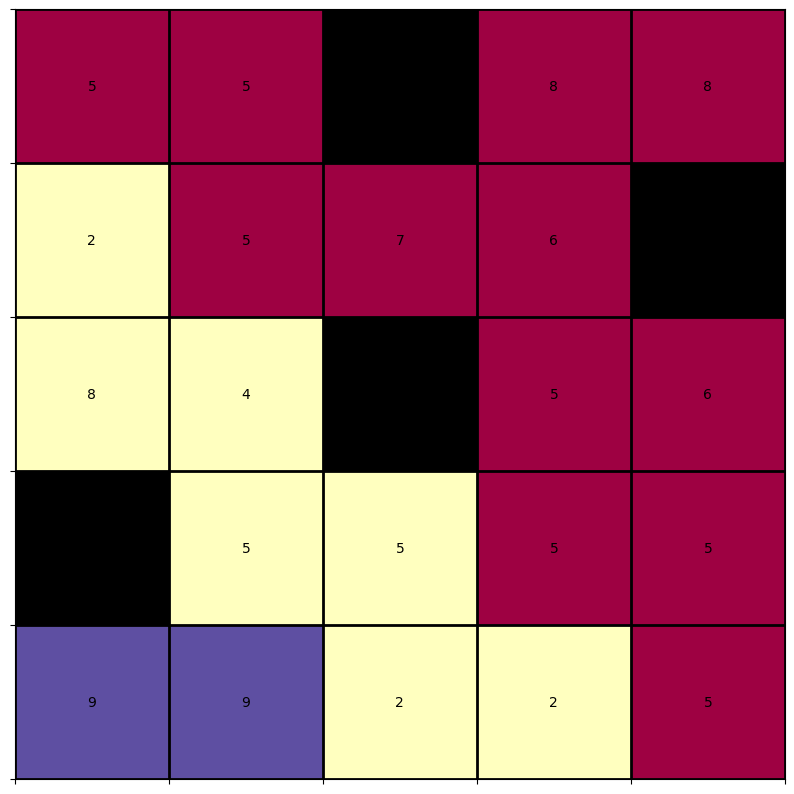

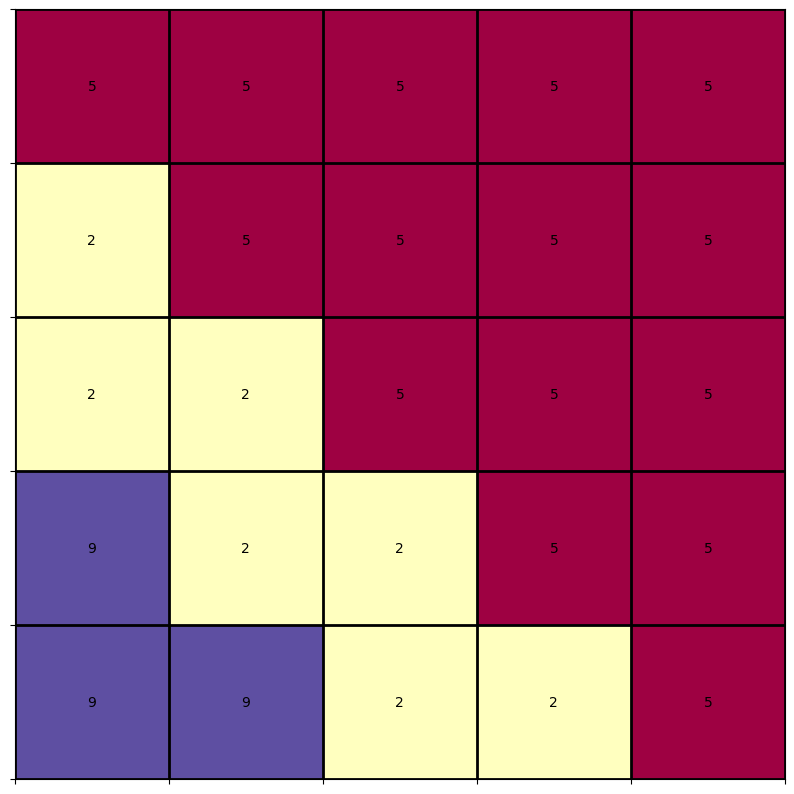

In [17]:
solve(demo, demo_yellow)

In [ ]:
solve(board, board_yellow)